# Phase 2: Feature Exploration & Analysis

## Objectives
1. Systematically explore features from the pre-trained SAE
2. Find max-activating examples for top features
3. Visualize feature activation patterns across diverse texts
4. Build interactive exploration tools
5. Analyze feature co-activation patterns
6. Integrate with Neuronpedia for feature interpretation

## What We'll Learn
- How to systematically analyze SAE features
- What makes specific features activate
- How to interpret feature meanings from activation patterns
- Which features co-activate (fire together)
- How to build reusable exploration tools

## Prerequisites
- Completed Phase 1 (model loaded, SAE loaded, initial activations cached)
- Cached data: `../data/phase1_activations.pt`

In [1]:
# ============================================================================
# CELL 2: Import Libraries
# ============================================================================

import torch
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings('ignore')

# TransformerLens and SAELens
from transformer_lens import HookedTransformer
from sae_lens import SAE

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✅ All libraries imported successfully!
PyTorch version: 2.9.0+cpu
Device: cpu


In [2]:
# ============================================================================
# CELL 3: Load LLM & SAE (with Multiple SAE Options)
# ============================================================================

print("🔧 Loading GPT-2 and SAE...")
print("=" * 70)

# Load model (this stays the same)
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    device="cpu"
)

print(f"✅ Model loaded: {model.cfg.model_name}")

# SAE Selection
# Available SAEs for GPT2-Small
available_saes = {
    "6-res-jb": {
        "description": "Layer 6 Residual Stream (Joseph Bloom)",
        "hook_point": "blocks.6.hook_resid_pre",
        "path": "~/.cache/sae_lens/blocks.6.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "8-res-jb": {
        "description": "Layer 8 Residual Stream (Joseph Bloom)",
        "hook_point": "blocks.8.hook_resid_pre",
        "path": "~/.cache/sae_lens/blocks.8.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "10-res-jb": {
        "description": "Layer 10 Residual Stream (Joseph Bloom)",
        "hook_point": "blocks.10.hook_resid_pre",
        "path": "~/.cache/sae_lens/blocks.10.hook_resid_pre",
        "d_in": 768,
        "d_sae": 24576
    },
    "6-mlp-out": {
        "description": "Layer 6 MLP Output",
        "hook_point": "blocks.6.hook_mlp_out",
        "path": "~/.cache/sae_lens/blocks.6.hook_mlp_out",
        "d_in": 768,
        "d_sae": 24576
    }
}

# Display available SAEs
print("\n📚 Available SAEs:")
for idx, (key, info) in enumerate(available_saes.items(), 1):
    print(f"  {idx}. {key}: {info['description']}")

# SELECT WHICH SAE TO USE HERE:
selected_sae = "6-res-jb"  # Change this to select different SAE

print(f"\n🎯 Selected SAE: {selected_sae}")
print(f"   Description: {available_saes[selected_sae]['description']}")

# Load the selected SAE
sae_info = available_saes[selected_sae]
hook_name = sae_info["hook_point"]

cache_path = os.path.expanduser(sae_info["path"])

try:
    sae = SAE.load_from_disk(path=cache_path, device="cpu")
    print(f"\n✅ SAE loaded successfully!")
    print(f"   Architecture: {sae_info['d_in']} → {sae_info['d_sae']} features")
    print(f"   Hook point: {hook_name}")
except FileNotFoundError:
    print(f"\n⚠️  SAE not found at: {cache_path}")
    print(f"   You may need to download it first using SAELens.")
    print(f"   Example: SAE.from_pretrained(...)")
    raise

print("\n" + "=" * 70)
print("✅ Setup complete! Ready to analyze features.")

🔧 Loading GPT-2 and SAE...


`torch_dtype` is deprecated! Use `dtype` instead!


Loaded pretrained model gpt2-small into HookedTransformer
✅ Model loaded: gpt2

📚 Available SAEs:
  1. 6-res-jb: Layer 6 Residual Stream (Joseph Bloom)
  2. 8-res-jb: Layer 8 Residual Stream (Joseph Bloom)
  3. 10-res-jb: Layer 10 Residual Stream (Joseph Bloom)
  4. 6-mlp-out: Layer 6 MLP Output

🎯 Selected SAE: 6-res-jb
   Description: Layer 6 Residual Stream (Joseph Bloom)

✅ SAE loaded successfully!
   Architecture: 768 → 24576 features
   Hook point: blocks.6.hook_resid_pre

✅ Setup complete! Ready to analyze features.


In [3]:
# ============================================================================
# CELL 4: Extract Features from Texts
# ============================================================================

print("🔍 Extracting activations and features from sample texts...")
print("=" * 70)

# Sample texts to analyze
texts = [
    "The Eiffel Tower is in Paris",
    "Python is a programming language",
    "The cat sat on the mat",
    "Machine learning models learn patterns",
]

print(f"Analyzing {len(texts)} initial texts...\n")

# Extract activations and features
all_features = []

for text in texts:
    # Extract activation from model
    logits, cache = model.run_with_cache(text)
    acts = cache[hook_name][0, -1, :]  # Last token activation
    
    # Get SAE features
    with torch.no_grad():
        features = sae.encode(acts.unsqueeze(0))
        all_features.append(features[0])
        
        # Show top 5 for each text
        top_vals, top_indices = features[0].topk(5)
        print(f"'{text}'")
        print(f"Top 5 features:")
        for idx, val in zip(top_indices, top_vals):
            print(f"  Feature #{idx.item()}: {val.item():.2f}")
        print()

# Stack for analysis
all_features = torch.stack(all_features)
print(f"📊 Total feature activations: {all_features.shape}")
print(f"   → {all_features.shape[0]} texts analyzed")
print(f"   → {all_features.shape[1]} features per text (most are zero due to sparsity)")

🔍 Extracting activations and features from sample texts...
Analyzing 4 initial texts...

'The Eiffel Tower is in Paris'
Top 5 features:
  Feature #9191: 47.03
  Feature #8654: 13.49
  Feature #10032: 5.68
  Feature #5656: 4.01
  Feature #8167: 3.67

'Python is a programming language'
Top 5 features:
  Feature #1676: 28.07
  Feature #17833: 21.14
  Feature #5816: 9.91
  Feature #12215: 8.82
  Feature #11825: 4.76

'The cat sat on the mat'
Top 5 features:
  Feature #19196: 49.34
  Feature #14904: 7.95
  Feature #20572: 7.63
  Feature #7388: 5.74
  Feature #15413: 5.52

'Machine learning models learn patterns'
Top 5 features:
  Feature #23421: 33.08
  Feature #7777: 6.19
  Feature #15821: 5.54
  Feature #15989: 5.00
  Feature #24559: 3.80

📊 Total feature activations: torch.Size([4, 24576])
   → 4 texts analyzed
   → 24576 features per text (most are zero due to sparsity)


In [4]:
# ============================================================================
# CELL 5: Find Most Frequently Active Features
# ============================================================================

print("\n🎯 Finding Most Frequently Active Features Across All Texts")
print("=" * 70)

# Count how many times each feature is active
feature_counts = (all_features > 0).sum(dim=0)

# Get top most frequent features
most_freq_features = 20
top_frequent_features = feature_counts.topk(most_freq_features)

print(f"\nTop {most_freq_features} Most Frequently Active Features:")
for rank, (count, idx) in enumerate(zip(top_frequent_features.values, top_frequent_features.indices), 1):
    print(f"  {rank}. Feature #{idx.item()}: active in {count.item()}/{len(texts)} texts")

# Add interpretation
print("\n💡 Interpretation:")
all_active_count = sum(1 for count in top_frequent_features.values if count.item() == len(texts))
if all_active_count > 0:
    print(f"   → {all_active_count} of the top {most_freq_features} features activate in ALL texts")
    print(f"   → These are likely 'universal' features representing:")
    print(f"      • Basic syntactic structures")
    print(f"      • Common grammatical patterns")
    print(f"      • General semantic processing")
    print(f"   → Later we'll find 'selective' features that distinguish content types")
else:
    print(f"   → Features show varying activation patterns across texts")
    print(f"   → This suggests more specialized feature behavior")

# Save top 10 for visualization
frequent_features = top_frequent_features.indices[:10].tolist()
print(f"\n💾 Saved top 10 for heatmap visualization: {frequent_features}")


🎯 Finding Most Frequently Active Features Across All Texts

Top 20 Most Frequently Active Features:
  1. Feature #3639: active in 4/4 texts
  2. Feature #5766: active in 4/4 texts
  3. Feature #19740: active in 3/4 texts
  4. Feature #8774: active in 3/4 texts
  5. Feature #1622: active in 3/4 texts
  6. Feature #19960: active in 2/4 texts
  7. Feature #18146: active in 2/4 texts
  8. Feature #17787: active in 2/4 texts
  9. Feature #12873: active in 2/4 texts
  10. Feature #22371: active in 2/4 texts
  11. Feature #14556: active in 2/4 texts
  12. Feature #12215: active in 2/4 texts
  13. Feature #20957: active in 2/4 texts
  14. Feature #21631: active in 2/4 texts
  15. Feature #21869: active in 2/4 texts
  16. Feature #6861: active in 2/4 texts
  17. Feature #13178: active in 2/4 texts
  18. Feature #23227: active in 2/4 texts
  19. Feature #11114: active in 2/4 texts
  20. Feature #4729: active in 2/4 texts

💡 Interpretation:
   → 2 of the top 20 features activate in ALL texts
   

In [5]:
# ============================================================================
# CELL 6: Load Larger Diverse Dataset
# ============================================================================

print("\n🧪 Loading Larger Diverse Test Dataset")
print("=" * 70)

# Create a much larger and more diverse dataset
diverse_texts = [
    # Python code (10 examples)
    "def factorial(n):\n    return 1 if n == 0 else n * factorial(n-1)",
    "import torch\nimport numpy as np\nfrom transformers import AutoModel",
    "class NeuralNetwork(nn.Module):\n    def __init__(self):",
    "for i in range(len(data)):\n    result.append(data[i] ** 2)",
    "try:\n    x = int(input())\nexcept ValueError:\n    print('Error')",
    "lambda x: x ** 2 + 3 * x - 5",
    "if __name__ == '__main__':\n    main()",
    "return [x for x in lst if x > 0]",
    "print(f'Result: {sum(values) / len(values):.2f}')",
    "pip install transformers torch numpy pandas",
    
    # URLs and web content (10 examples)
    "https://www.github.com/anthropics/claude",
    "Visit our website at http://example.com/products",
    "<html><body><h1>Welcome</h1></body></html>",
    "<div class='container'><p>Content here</p></div>",
    "GET /api/v1/users HTTP/1.1",
    "mailto:support@example.com",
    "www.stackoverflow.com/questions/12345",
    "ftp://files.example.org/downloads/",
    "Click here: https://bit.ly/abc123",
    "Check out reddit.com/r/machinelearning",
    
    # Mathematical notation (10 examples)
    "f(x) = x^2 + 2x + 1",
    "∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C",
    "lim(x→0) sin(x)/x = 1",
    "∑(i=1 to n) i = n(n+1)/2",
    "√(a^2 + b^2) = c",
    "P(A|B) = P(B|A)P(A) / P(B)",
    "E = mc^2",
    "∇f(x,y) = (∂f/∂x, ∂f/∂y)",
    "det([[a,b],[c,d]]) = ad - bc",
    "sin^2(θ) + cos^2(θ) = 1",
    
    # Non-English languages (10 examples)
    "Bonjour, comment allez-vous aujourd'hui?",
    "你好，今天天气怎么样？",
    "Hola, ¿cómo estás?",
    "Guten Tag, wie geht es Ihnen?",
    "Здравствуйте, как дела?",
    "こんにちは、元気ですか？",
    "مرحبا، كيف حالك؟",
    "안녕하세요, 잘 지내셨어요?",
    "Ciao, come stai?",
    "Olá, como você está?",
    
    # Social media/casual with emojis (10 examples)
    "omg that's so funny 😂😂😂",
    "can't wait for the weekend!! 🎉🎊",
    "just got coffee ☕ feeling good ✨",
    "bruh why is this happening 💀",
    "yaaaas queen!!! 👑💅✨",
    "ngl this is pretty cool 🔥",
    "lmaooo i'm dying 😭😭",
    "tbh idk what to do 🤷‍♀️",
    "mood af rn 💯",
    "this slaps fr fr 🎵🔥",
    
    # Formal/academic (10 examples)
    "The phenomenon was observed under controlled laboratory conditions.",
    "In accordance with the aforementioned regulations, we hereby submit this proposal.",
    "The hypothesis was tested using a double-blind randomized controlled trial.",
    "Pursuant to Article 12, Section 3 of the aforementioned statute.",
    "The results indicate a statistically significant correlation (p < 0.05).",
    "This paper examines the theoretical frameworks underlying modern economics.",
    "The defendant pleaded not guilty to all charges in the indictment.",
    "We acknowledge the contributions of all co-authors and funding agencies.",
    "The experimental methodology followed established protocols.",
    "In conclusion, further research is warranted to investigate this phenomenon.",
    
    # Regular conversational English (10 examples)
    "Hey, what's up? Want to grab lunch later?",
    "I think the meeting went pretty well today.",
    "The weather is nice, maybe we should go for a walk.",
    "Did you see that movie everyone's talking about?",
    "I'm planning a trip to Japan next summer.",
    "That restaurant has the best pizza in town.",
    "My cat keeps knocking things off the table.",
    "The traffic was terrible this morning.",
    "I need to finish this project by Friday.",
    "Let's catch up over coffee sometime.",
]

print(f"Loaded {len(diverse_texts)} diverse texts across 7 categories:")
print(f"   → 10 Python code examples")
print(f"   → 10 URLs/web content")
print(f"   → 10 Mathematical notation")
print(f"   → 10 Non-English languages")
print(f"   → 10 Social media/casual with emojis")
print(f"   → 10 Formal/academic writing")
print(f"   → 10 Regular conversational English")
print(f"\nThis should reveal more specialized features!\n")

# Extract features for all diverse texts
diverse_features = []

for text in diverse_texts:
    logits, cache = model.run_with_cache(text)
    acts = cache[hook_name][0, -1, :]
    
    with torch.no_grad():
        features = sae.encode(acts.unsqueeze(0))
        diverse_features.append(features[0])

# Stack for analysis
diverse_features = torch.stack(diverse_features)

print(f"✅ Extracted features for {len(diverse_texts)} texts")
print(f"   Feature tensor shape: {diverse_features.shape}")
print(f"   → {diverse_features.shape[0]} texts analyzed")
print(f"   → {diverse_features.shape[1]} features per text")



🧪 Loading Larger Diverse Test Dataset
Loaded 70 diverse texts across 7 categories:
   → 10 Python code examples
   → 10 URLs/web content
   → 10 Mathematical notation
   → 10 Non-English languages
   → 10 Social media/casual with emojis
   → 10 Formal/academic writing
   → 10 Regular conversational English

This should reveal more specialized features!

✅ Extracted features for 70 texts
   Feature tensor shape: torch.Size([70, 24576])
   → 70 texts analyzed
   → 24576 features per text


In [6]:
# ============================================================================
# CELL 7: Discover and Analyze Most Interesting Features
# ============================================================================

print("\n🔬 Finding and Analyzing Most Interesting Features")
print("=" * 70)

# APPROACH 1: Feature with highest max activation (strongest)
max_activations = diverse_features.max(dim=0)
strongest_feature_idx = max_activations.values.argmax().item()
strongest_feature_val = max_activations.values.max().item()

print(f"\n1️⃣  STRONGEST Feature (highest activation value):")
print(f"   Feature #{strongest_feature_idx}")
print(f"   Max activation: {strongest_feature_val:.2f}")

# APPROACH 2: Most frequently active feature
feature_frequency = (diverse_features > 0).sum(dim=0)
most_frequent_feature_idx = feature_frequency.argmax().item()
most_frequent_count = feature_frequency.max().item()

print(f"\n2️⃣  MOST FREQUENT Feature (active in most texts):")
print(f"   Feature #{most_frequent_feature_idx}")
print(f"   Active in: {most_frequent_count}/{len(diverse_texts)} texts")

# APPROACH 3: Most selective feature (high activation but rare)
activation_threshold = 5.0  # Minimum to be considered a "strong" activation
strong_activations = (diverse_features > activation_threshold)  # Boolean mask
strong_activation_counts = strong_activations.sum(dim=0)  # Count per feature

# Find features that activate strongly on at least 1 text
has_strong_activation = strong_activation_counts > 0

# Among those, find the one active in the FEWEST texts
# Set infinite count for features with no strong activations
selectivity_counts = strong_activation_counts.clone().float()
selectivity_counts[~has_strong_activation] = float('inf')

# Get the feature with minimum count (most selective)
most_selective_idx = selectivity_counts.argmin().item()
selective_max_val = diverse_features[:, most_selective_idx].max().item()
selective_count = strong_activation_counts[most_selective_idx].item()
total_active_count = (diverse_features[:, most_selective_idx] > 0).sum().item()

print(f"\n3️⃣  MOST SELECTIVE Feature (specialist - high activation, few texts):")
print(f"   Feature #{most_selective_idx}")
print(f"   Max activation: {selective_max_val:.2f}")
print(f"   Strong activations (>{activation_threshold}) in: {selective_count}/{len(diverse_texts)} texts ({100*selective_count/len(diverse_texts):.1f}%)")
print(f"   Any activation (>0) in: {total_active_count}/{len(diverse_texts)} texts")

# Show which features we'll analyze in detail
features_to_analyze = []
labels = []

if strongest_feature_idx not in features_to_analyze:
    features_to_analyze.append(strongest_feature_idx)
    labels.append("STRONGEST")
    
if most_frequent_feature_idx not in features_to_analyze:
    features_to_analyze.append(most_frequent_feature_idx)
    labels.append("MOST FREQUENT")
    
if most_selective_idx not in features_to_analyze:
    features_to_analyze.append(most_selective_idx)
    labels.append("MOST SELECTIVE")

print(f"\n💡 Analyzing {len(features_to_analyze)} distinct features in detail:")
for feat_idx, label in zip(features_to_analyze, labels):
    print(f"   → Feature #{feat_idx} ({label})")

print("\n" + "=" * 70)

# Analyze each feature in detail
for i, feature_idx in enumerate(features_to_analyze):
    label = labels[i]
    
    print(f"\n📊 Feature #{feature_idx} ({label})")
    print("-" * 70)
    
    # Get activations for this feature
    feature_acts = diverse_features[:, feature_idx]
    
    # Create dataframe sorted by activation
    df = pd.DataFrame({
        'Text': diverse_texts,
        'Activation': feature_acts.numpy(),
        'Active': ['✓' if act > 0 else '✗' for act in feature_acts]
    })
    df = df.sort_values('Activation', ascending=False)
    
    print("\nTop 10 activating texts:")
    display(df.head(10))
    
    # Statistics
    active_count = (feature_acts > 0).sum().item()
    mean_act = feature_acts[feature_acts > 0].mean().item() if active_count > 0 else 0
    max_act = feature_acts.max().item()
    
    print(f"\n📈 Statistics:")
    print(f"   Active in: {active_count}/{len(diverse_texts)} texts ({100*active_count/len(diverse_texts):.1f}%)")
    print(f"   Mean activation (when active): {mean_act:.3f}")
    print(f"   Max activation: {max_act:.3f}")
    
    print(f"\n🔗 Explore on Neuronpedia:")
    print(f"   https://neuronpedia.org/gpt2-small/6-res-jb/{feature_idx}")
    
    if i < len(features_to_analyze) - 1:
        print("\n" + "=" * 70)

# APPROACH 4: Category-Specific Feature Analysis (by MAX activation)
# Look for features that fire VERY STRONGLY on at least one example in each category

categories = {
    'Python': list(range(0, 10)),
    'URLs/Web': list(range(10, 20)),
    'Math': list(range(20, 30)),
    'Non-English': list(range(30, 40)),
    'Social/Emoji': list(range(40, 50)),
    'Formal': list(range(50, 60)),
    'Conversational': list(range(60, 70))
}

print("\n" + "=" * 70)
print("\n4️⃣  CATEGORY-SPECIFIC FEATURE ANALYSIS (by MAX activation)")
print("=" * 70)
print("For each category, finding features with highest activation")
print("and checking if they specialize in that category (activate strongly")
print("inside the category but rarely outside it):\n")

best_specialist = None
best_specialist_score = -1
category_specialists = {}  # Store best specialist for each category
category_has_specialist = {}  # Track if category has a true specialist

for cat_name, indices in categories.items():
    print(f"\n{cat_name}:")
    cat_features = diverse_features[indices, :]
    
    # Find features with highest MAX activation in this category
    cat_max = cat_features.max(dim=0)
    top_features = cat_max.values.topk(5)
    
    cat_best_specialist = None
    cat_best_score = -1
    
    for rank, (max_val, feat_idx) in enumerate(zip(top_features.values, top_features.indices), 1):
        feat_idx_item = feat_idx.item()
        
        # Check how often it activates STRONGLY (>5.0) outside this category
        other_indices = [i for i in range(len(diverse_texts)) if i not in indices]
        strong_outside = (diverse_features[other_indices, feat_idx_item] > 5.0).sum().item()
        strong_inside = (diverse_features[indices, feat_idx_item] > 5.0).sum().item()
        
        # Calculate specialist score: strong activations inside - strong activations outside
        specialist_score = strong_inside - strong_outside
        
        # Track the best specialist for this category
        if specialist_score > cat_best_score:
            cat_best_score = specialist_score
            cat_best_specialist = feat_idx_item
        
        # Track the best specialist overall
        if specialist_score > best_specialist_score:
            best_specialist_score = specialist_score
            best_specialist = {
                'idx': feat_idx_item,
                'category': cat_name,
                'max_val': max_val.item(),
                'strong_inside': strong_inside,
                'strong_outside': strong_outside,
                'score': specialist_score
            }
        
        print(f"  {rank}. Feature #{feat_idx_item}: max={max_val:.2f}, strong(>5.0) inside={strong_inside}/10, outside={strong_outside}/60")
    
    # Store the top feature for this category and whether it's a true specialist
    if cat_best_specialist is not None:
        category_specialists[cat_name] = cat_best_specialist
        category_has_specialist[cat_name] = (cat_best_score > 0)
        
        if cat_best_score > 0:
            print(f"  ✓ True specialist found: Feature #{cat_best_specialist} (score: {cat_best_score})")
        else:
            print(f"  ✗ No specialist (top feature activates more outside than inside)")
        
        print(f"  🔗 Top feature for {cat_name}: https://neuronpedia.org/gpt2-small/6-res-jb/{cat_best_specialist}")

print("\n" + "=" * 70)

# Summary of findings
num_specialists = sum(category_has_specialist.values())

if best_specialist and best_specialist['score'] > 0:
    print(f"\n🎯 Best Specialist Feature Found:")
    print(f"   Feature #{best_specialist['idx']}")
    print(f"   Category: {best_specialist['category']}")
    print(f"   Max activation: {best_specialist['max_val']:.2f}")
    print(f"   Strong activations (>5.0) in {best_specialist['category']}: {best_specialist['strong_inside']}/10")
    print(f"   Strong activations (>5.0) outside {best_specialist['category']}: {best_specialist['strong_outside']}/60")
    print(f"   Specialist score: {best_specialist['score']}")
    print(f"\n🔗 Explore on Neuronpedia:")
    print(f"   https://neuronpedia.org/gpt2-small/6-res-jb/{best_specialist['idx']}")
    print(f"\n📊 Summary: Found {num_specialists}/{len(categories)} categories with true specialist features")
else:
    print(f"\n⚠️  No True Specialist Features Found")
    print(f"   All features that activate strongly in one category also activate")
    print(f"   strongly in other categories (negative or zero specialist scores).")
    print(f"\n📊 Summary: 0/{len(categories)} categories have specialist features")

print("\n💭 Interpretation:")
print("   - STRONGEST feature: Highest peak activation (may still be general)")
print("   - FREQUENT feature: Activates consistently across many texts")
print("   - SELECTIVE feature: High activation but only on specific text types")
print("   - CATEGORY ANALYSIS: Searches for specialists in each category")
print("   - Specialist score = (strong in category) - (strong outside category)")
print("   - Positive scores indicate specialization; negative scores indicate generalization")

if num_specialists == 0:
    print("\n   ⚠️  Key Finding: This SAE did not learn category-specific specialists")
    print("   This demonstrates a core challenge in mechanistic interpretability:")
    print("   SAEs don't always decompose into clean, monosemantic features for every domain.")
else:
    print(f"\n   ✓ Found {num_specialists} specialist feature(s) - true category-specific patterns detected!")


🔬 Finding and Analyzing Most Interesting Features

1️⃣  STRONGEST Feature (highest activation value):
   Feature #23575
   Max activation: 48.83

2️⃣  MOST FREQUENT Feature (active in most texts):
   Feature #18043
   Active in: 33/70 texts

3️⃣  MOST SELECTIVE Feature (specialist - high activation, few texts):
   Feature #295
   Max activation: 6.28
   Strong activations (>5.0) in: 1/70 texts (1.4%)
   Any activation (>0) in: 2/70 texts

💡 Analyzing 3 distinct features in detail:
   → Feature #23575 (STRONGEST)
   → Feature #18043 (MOST FREQUENT)
   → Feature #295 (MOST SELECTIVE)


📊 Feature #23575 (STRONGEST)
----------------------------------------------------------------------

Top 10 activating texts:


,Text,Activation,Active
13,<div class='container'><p>Content here</p></div>,48.826561,✓
12,<html><body><h1>Welcome</h1></body></html>,44.523075,✓
49,this slaps fr fr 🎵🔥,0.600993,✓
51,In accordance with the aforementioned regulati...,0.000000,✗
50,The phenomenon was observed under controlled l...,0.000000,✗
48,mood af rn 💯,0.000000,✗
47,tbh idk what to do 🤷‍♀️,0.000000,✗
46,lmaooo i'm dying 😭😭,0.000000,✗
45,ngl this is pretty cool 🔥,0.000000,✗
52,The hypothesis was tested using a double-blind...,0.000000,✗



📈 Statistics:
   Active in: 3/70 texts (4.3%)
   Mean activation (when active): 31.317
   Max activation: 48.827

🔗 Explore on Neuronpedia:
   https://neuronpedia.org/gpt2-small/6-res-jb/23575


📊 Feature #18043 (MOST FREQUENT)
----------------------------------------------------------------------

Top 10 activating texts:


,Text,Activation,Active
21,∫(x^2 + 3x)dx = x^3/3 + 3x^2/2 + C,7.019273,✓
24,√(a^2 + b^2) = c,6.319774,✓
29,sin^2(θ) + cos^2(θ) = 1,5.162304,✓
31,你好，今天天气怎么样？,4.968639,✓
3,for i in range(len(data)):\n result.append(...,4.471064,✓
22,lim(x→0) sin(x)/x = 1,4.428233,✓
8,print(f'Result: {sum(values) / len(values):.2f}'),3.705222,✓
44,yaaaas queen!!! 👑💅✨,3.700651,✓
37,"안녕하세요, 잘 지내셨어요?",3.357204,✓
27,"∇f(x,y) = (∂f/∂x, ∂f/∂y)",2.484785,✓



📈 Statistics:
   Active in: 33/70 texts (47.1%)
   Mean activation (when active): 1.949
   Max activation: 7.019

🔗 Explore on Neuronpedia:
   https://neuronpedia.org/gpt2-small/6-res-jb/18043


📊 Feature #295 (MOST SELECTIVE)
----------------------------------------------------------------------

Top 10 activating texts:


,Text,Activation,Active
14,GET /api/v1/users HTTP/1.1,6.282235,✓
41,can't wait for the weekend!! 🎉🎊,0.041764,✓
51,In accordance with the aforementioned regulati...,0.000000,✗
50,The phenomenon was observed under controlled l...,0.000000,✗
49,this slaps fr fr 🎵🔥,0.000000,✗
48,mood af rn 💯,0.000000,✗
47,tbh idk what to do 🤷‍♀️,0.000000,✗
46,lmaooo i'm dying 😭😭,0.000000,✗
45,ngl this is pretty cool 🔥,0.000000,✗
35,こんにちは、元気ですか？,0.000000,✗



📈 Statistics:
   Active in: 2/70 texts (2.9%)
   Mean activation (when active): 3.162
   Max activation: 6.282

🔗 Explore on Neuronpedia:
   https://neuronpedia.org/gpt2-small/6-res-jb/295


4️⃣  CATEGORY-SPECIFIC FEATURE ANALYSIS (by MAX activation)
For each category, finding features with highest activation
and checking if they specialize in that category (activate strongly
inside the category but rarely outside it):


Python:
  1. Feature #7155: max=38.02, strong(>5.0) inside=1/10, outside=0/60
  2. Feature #14848: max=30.14, strong(>5.0) inside=1/10, outside=0/60
  3. Feature #3252: max=28.41, strong(>5.0) inside=1/10, outside=0/60
  4. Feature #17352: max=25.87, strong(>5.0) inside=1/10, outside=0/60
  5. Feature #3197: max=25.71, strong(>5.0) inside=6/10, outside=2/60
  ✓ True specialist found: Feature #3197 (score: 4)
  🔗 Top feature for Python: https://neuronpedia.org/gpt2-small/6-res-jb/3197

URLs/Web:
  1. Feature #23575: max=48.83, strong(>5.0) inside=2/10, outside=0/60
  2


📈 Creating Feature Activation Heatmap


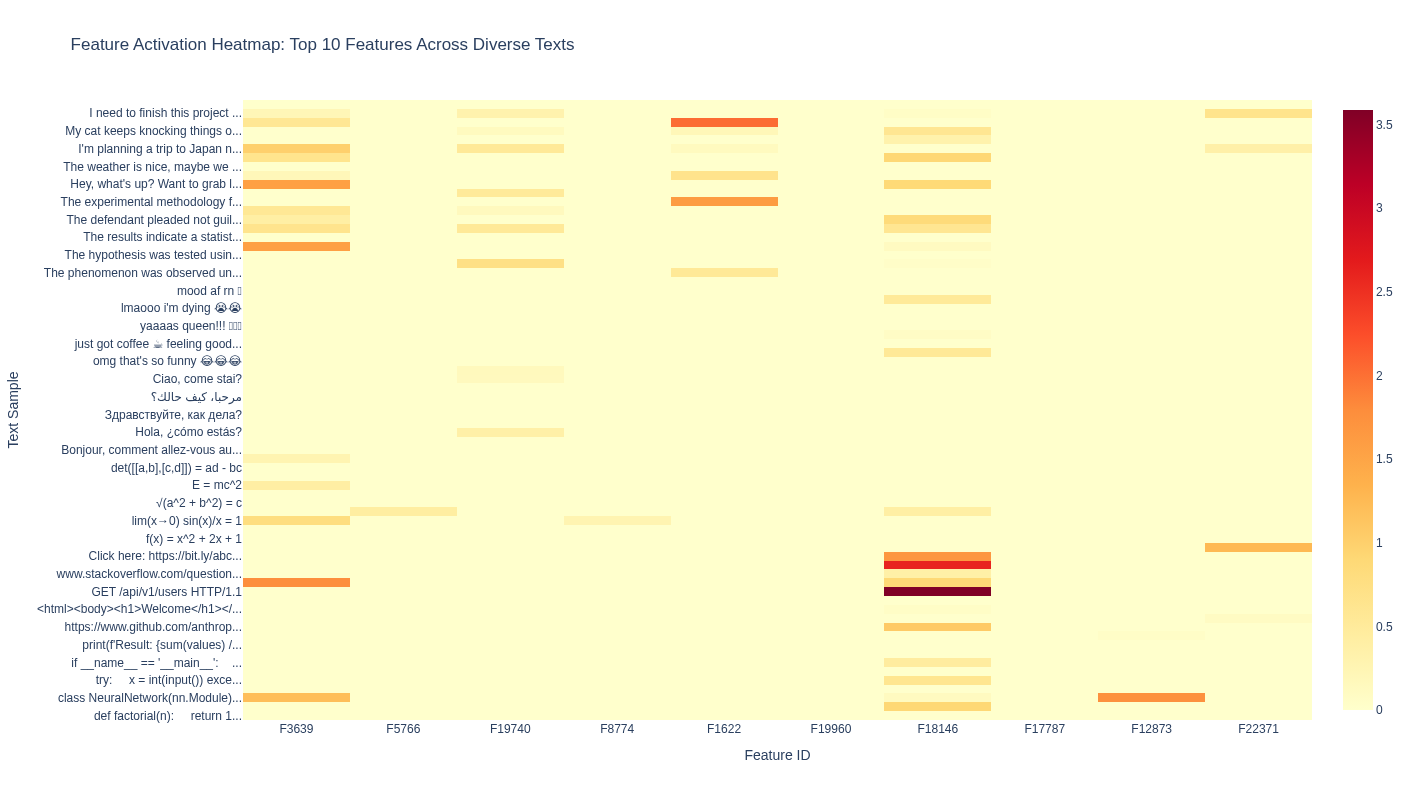


💡 Darker colors = stronger activation
   Look for patterns: which text types activate which features?

📊 Creating Feature Activation Heatmap For Top Features Only

Visualizing 9 features across 70 texts
Features: [23575, 18043, 295, 3197, 13442, 16247, 11722, 17363, 11542]


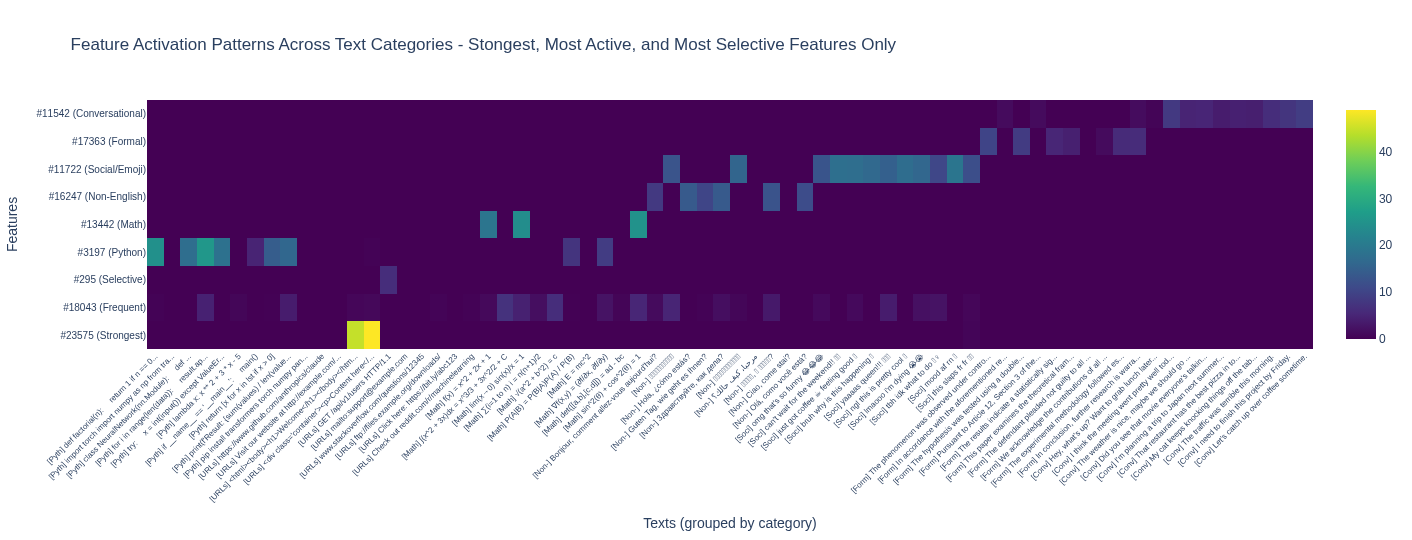


💡 Interpretation:
   - Darker colors = higher activation
   - Look for vertical bands (features that activate on specific categories)
   - Look for horizontal bands (texts that activate many features)
   - Category prefixes: Pyth=Python, URLs=URLs/Web, Math=Math, Non-=Non-English,
                        Soci=Social/Emoji, Form=Formal, Conv=Conversational


In [7]:
# ============================================================================
# CELL 8: Feature Activation Heatmap
# ============================================================================

print("\n📈 Creating Feature Activation Heatmap")
print("=" * 70)

# Select top 10 features for visualization
top_features_to_viz = frequent_features[:10]

# Create activation matrix
activation_matrix = diverse_features[:, top_features_to_viz].numpy()

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=activation_matrix,
    x=[f"F{f}" for f in top_features_to_viz],
    y=[text[:30] + "..." if len(text) > 30 else text for text in diverse_texts],
    colorscale='YlOrRd',
    hoverongaps=False,
    hovertemplate='Text: %{y}<br>Feature: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig.update_layout(
    title="Feature Activation Heatmap: Top 10 Features Across Diverse Texts",
    xaxis_title="Feature ID",
    yaxis_title="Text Sample",
    height=800,
    width=900
)

fig.show()

print("\n💡 Darker colors = stronger activation")
print("   Look for patterns: which text types activate which features?")



print("\n📊 Creating Feature Activation Heatmap For Top Features Only")
print("=" * 70)

# Select features to visualize (mix of different types)
features_to_viz = []
feature_labels = []

# Add the interesting features we found
if strongest_feature_idx not in features_to_viz:
    features_to_viz.append(strongest_feature_idx)
    feature_labels.append(f"#{strongest_feature_idx} (Strongest)")

if most_frequent_feature_idx not in features_to_viz:
    features_to_viz.append(most_frequent_feature_idx)
    feature_labels.append(f"#{most_frequent_feature_idx} (Frequent)")

if most_selective_idx not in features_to_viz:
    features_to_viz.append(most_selective_idx)
    feature_labels.append(f"#{most_selective_idx} (Selective)")

# Add the best specialist from each category (if they're different)
for cat_name, feat_idx in category_specialists.items():
    if feat_idx not in features_to_viz:
        features_to_viz.append(feat_idx)
        feature_labels.append(f"#{feat_idx} ({cat_name})")

print(f"\nVisualizing {len(features_to_viz)} features across {len(diverse_texts)} texts")
print(f"Features: {features_to_viz}")

# Create activation matrix for these features
activation_matrix = []
for feat_idx in features_to_viz:
    activations = diverse_features[:, feat_idx].numpy()
    activation_matrix.append(activations)

activation_matrix = np.array(activation_matrix)

# Create text labels with category prefixes
text_labels = []
categories_ordered = {
    'Python': list(range(0, 10)),
    'URLs/Web': list(range(10, 20)),
    'Math': list(range(20, 30)),
    'Non-English': list(range(30, 40)),
    'Social/Emoji': list(range(40, 50)),
    'Formal': list(range(50, 60)),
    'Conversational': list(range(60, 70))
}

for i, text in enumerate(diverse_texts):
    # Find which category this text belongs to
    cat_label = ""
    for cat_name, indices in categories_ordered.items():
        if i in indices:
            cat_label = cat_name[:4]  # First 4 letters
            break
    
    # Truncate text for label
    text_short = text[:40] + "..." if len(text) > 40 else text
    text_labels.append(f"[{cat_label}] {text_short}")

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=activation_matrix,
    x=text_labels,
    y=feature_labels,
    colorscale='Viridis',
    hoverongaps=False,
    hovertemplate='Feature: %{y}<br>Text: %{x}<br>Activation: %{z:.2f}<extra></extra>'
))

fig.update_layout(
    title='Feature Activation Patterns Across Text Categories - Stongest, Most Active, and Most Selective Features Only',
    xaxis_title='Texts (grouped by category)',
    yaxis_title='Features',
    height=max(400, len(features_to_viz) * 60),
    width=1400,
    xaxis={'tickangle': -45, 'tickfont': {'size': 8}},
    yaxis={'tickfont': {'size': 10}}
)

fig.show()

print("\n💡 Interpretation:")
print("   - Darker colors = higher activation")
print("   - Look for vertical bands (features that activate on specific categories)")
print("   - Look for horizontal bands (texts that activate many features)")
print("   - Category prefixes: Pyth=Python, URLs=URLs/Web, Math=Math, Non-=Non-English,")
print("                        Soci=Social/Emoji, Form=Formal, Conv=Conversational")

In [9]:
# ============================================================================
# CELL 9: Build Interactive Feature Explorer Function
# ============================================================================

def explore_feature(feature_idx, texts_to_test=None):
    """
    Explore a specific feature by testing it on custom texts
    
    Args:
        feature_idx: Feature number to explore
        texts_to_test: List of texts to test (optional, uses diverse_texts if None)
    """
    if texts_to_test is None:
        texts_to_test = diverse_texts
    
    print(f"\n🔍 Exploring Feature #{feature_idx}")
    print("=" * 70)
    print(f"🔗 Neuronpedia: https://neuronpedia.org/gpt2-small/6-res-jb/{feature_idx}")
    print()
    
    results = []
    for text in texts_to_test:
        # Get activation
        logits, cache = model.run_with_cache(text)
        acts = cache[hook_name][0, -1, :]
        
        # Get features
        with torch.no_grad():
            features = sae.encode(acts.unsqueeze(0))
            activation_val = features[0, feature_idx].item()
        
        results.append((text, activation_val))
    
    # Sort by activation
    results.sort(key=lambda x: x[1], reverse=True)
    
    print("Top Activating Texts:")
    for i, (text, val) in enumerate(results[:10], 1):
        print(f"  {i}. [{val:6.2f}] {text}")
    
    return results

# Test it with the STRONGEST feature we discovered in Cell 7
print("Testing the explorer function with dynamically discovered feature:")
print(f"Using Feature #{strongest_feature_idx} (strongest from Cell 7)")
explore_feature(strongest_feature_idx)


Testing the explorer function with dynamically discovered feature:
Using Feature #23575 (strongest from Cell 7)

🔍 Exploring Feature #23575
🔗 Neuronpedia: https://neuronpedia.org/gpt2-small/6-res-jb/23575

Top Activating Texts:
  1. [ 48.83] <div class='container'><p>Content here</p></div>
  2. [ 44.52] <html><body><h1>Welcome</h1></body></html>
  3. [  0.60] this slaps fr fr 🎵🔥
  4. [  0.00] def factorial(n):
    return 1 if n == 0 else n * factorial(n-1)
  5. [  0.00] import torch
import numpy as np
from transformers import AutoModel
  6. [  0.00] class NeuralNetwork(nn.Module):
    def __init__(self):
  7. [  0.00] for i in range(len(data)):
    result.append(data[i] ** 2)
  8. [  0.00] try:
    x = int(input())
except ValueError:
    print('Error')
  9. [  0.00] lambda x: x ** 2 + 3 * x - 5
  10. [  0.00] if __name__ == '__main__':
    main()


[("<div class='container'><p>Content here</p></div>", 48.826560974121094),
 ('<html><body><h1>Welcome</h1></body></html>', 44.523075103759766),
 ('this slaps fr fr 🎵🔥', 0.6009929776191711),
 ('def factorial(n):\n    return 1 if n == 0 else n * factorial(n-1)', 0.0),
 ('import torch\nimport numpy as np\nfrom transformers import AutoModel', 0.0),
 ('class NeuralNetwork(nn.Module):\n    def __init__(self):', 0.0),
 ('for i in range(len(data)):\n    result.append(data[i] ** 2)', 0.0),
 ("try:\n    x = int(input())\nexcept ValueError:\n    print('Error')", 0.0),
 ('lambda x: x ** 2 + 3 * x - 5', 0.0),
 ("if __name__ == '__main__':\n    main()", 0.0),
 ('return [x for x in lst if x > 0]', 0.0),
 ("print(f'Result: {sum(values) / len(values):.2f}')", 0.0),
 ('pip install transformers torch numpy pandas', 0.0),
 ('https://www.github.com/anthropics/claude', 0.0),
 ('Visit our website at http://example.com/products', 0.0),
 ('GET /api/v1/users HTTP/1.1', 0.0),
 ('mailto:support@example.com', 0.0)

In [10]:
# ============================================================================
# CELL 10: Feature Co-Activation Analysis
# ============================================================================

print("\n🤝 Feature Co-Activation Analysis")
print("=" * 70)

# For each text type category, which features activate together?
print("\nAnalyzing which features tend to activate together...\n")

# Get top 5 features for each text type category
categories = {
    'Geography': diverse_texts[0:3],
    'Code': diverse_texts[3:6],
    'Legal': diverse_texts[6:9],
    'Casual': diverse_texts[9:12],
    'Literature': diverse_texts[12:15],
    'News': diverse_texts[15:18],
}

for category, category_texts in categories.items():
    print(f"\n{category} Texts:")
    
    # Get features for this category
    category_feature_counts = torch.zeros(sae.cfg.d_sae)
    
    for text in category_texts:
        idx = diverse_texts.index(text)
        active_features = (diverse_features[idx] > 0)
        category_feature_counts += active_features.float()
    
    # Get most common features for this category
    top_5 = category_feature_counts.topk(5)
    
    print(f"  Most common features:")
    for feat_idx, count in zip(top_5.indices, top_5.values):
        print(f"    Feature #{feat_idx.item()}: active in {int(count.item())}/{len(category_texts)} texts")
        print(f"      → https://neuronpedia.org/gpt2-small/6-res-jb/{feat_idx.item()}")



🤝 Feature Co-Activation Analysis

Analyzing which features tend to activate together...


Geography Texts:
  Most common features:
    Feature #10895: active in 2/3 texts
      → https://neuronpedia.org/gpt2-small/6-res-jb/10895
    Feature #7825: active in 2/3 texts
      → https://neuronpedia.org/gpt2-small/6-res-jb/7825
    Feature #14588: active in 2/3 texts
      → https://neuronpedia.org/gpt2-small/6-res-jb/14588
    Feature #16915: active in 2/3 texts
      → https://neuronpedia.org/gpt2-small/6-res-jb/16915
    Feature #3197: active in 2/3 texts
      → https://neuronpedia.org/gpt2-small/6-res-jb/3197

Code Texts:
  Most common features:
    Feature #4790: active in 2/3 texts
      → https://neuronpedia.org/gpt2-small/6-res-jb/4790
    Feature #3197: active in 2/3 texts
      → https://neuronpedia.org/gpt2-small/6-res-jb/3197
    Feature #6791: active in 2/3 texts
      → https://neuronpedia.org/gpt2-small/6-res-jb/6791
    Feature #7467: active in 2/3 texts
      → https://ne

In [11]:
# ============================================================================
# CELL 11: Find Features for a Specific Concept (with Activation Strength)
# ============================================================================

def find_features_for_concept(concept_texts, top_k=5, activation_threshold=5.0):
    """
    Find features that consistently activate STRONGLY for a concept
    
    Args:
        concept_texts: List of texts representing a concept
        top_k: Number of top features to return
        activation_threshold: Minimum activation to be considered "strong"
    """
    print(f"\n🎯 Finding features for concept (analyzing {len(concept_texts)} texts)")
    print("=" * 70)
    
    # Accumulate feature activations with strength weighting
    accumulated_strong = torch.zeros(sae.cfg.d_sae)  # Count of strong activations
    accumulated_strength = torch.zeros(sae.cfg.d_sae)  # Sum of activation strengths
    
    for text in concept_texts:
        print(f"  Analyzing: '{text[:50]}...'")
        
        # Get features
        logits, cache = model.run_with_cache(text)
        acts = cache[hook_name][0, -1, :]
        
        with torch.no_grad():
            features = sae.encode(acts.unsqueeze(0))
            
            # Count strong activations (above threshold)
            accumulated_strong += (features[0] > activation_threshold).float()
            
            # Also accumulate total strength for mean calculation
            accumulated_strength += features[0]
    
    # Calculate mean activation strength (only for texts where it activated)
    mean_strength = torch.zeros_like(accumulated_strength)
    active_count = (accumulated_strength > 0).float()
    mean_strength[active_count > 0] = accumulated_strength[active_count > 0] / active_count[active_count > 0]
    
    # Find features with most strong activations
    top_features_by_strong = accumulated_strong.topk(top_k)
    
    # Also find features with highest mean activation strength
    top_features_by_mean = mean_strength.topk(top_k)
    
    print(f"\n📊 Top {top_k} features by STRONG activation consistency (>{activation_threshold}):")
    print("-" * 70)
    for rank, (count, idx) in enumerate(zip(top_features_by_strong.values, top_features_by_strong.indices), 1):
        mean_act = mean_strength[idx].item()
        consistency = (count.item() / len(concept_texts)) * 100
        print(f"  {rank}. Feature #{idx.item()}")
        print(f"     Strong activations: {int(count.item())}/{len(concept_texts)} texts ({consistency:.0f}%)")
        print(f"     Mean activation (all texts): {mean_act:.2f}")
        print(f"     → https://neuronpedia.org/gpt2-small/6-res-jb/{idx.item()}")
    
    print(f"\n📊 Top {top_k} features by MEAN activation strength:")
    print("-" * 70)
    for rank, (mean_val, idx) in enumerate(zip(top_features_by_mean.values, top_features_by_mean.indices), 1):
        strong_count = accumulated_strong[idx].item()
        consistency = (strong_count / len(concept_texts)) * 100
        print(f"  {rank}. Feature #{idx.item()}")
        print(f"     Mean activation: {mean_val:.2f}")
        print(f"     Strong activations (>{activation_threshold}): {int(strong_count)}/{len(concept_texts)} ({consistency:.0f}%)")
        print(f"     → https://neuronpedia.org/gpt2-small/6-res-jb/{idx.item()}")
    
    print("\n💡 Interpretation:")
    print(f"   - 'Strong activation consistency': Features that activate >{activation_threshold} most frequently")
    print(f"   - 'Mean activation strength': Features with highest average activation")
    print(f"   - True specialists should score high on BOTH metrics")
    
    return top_features_by_strong.indices.tolist()

# Test: Find features for "code/programming"
code_texts = [
    "def function(x): return x + 1",
    "import numpy as np",
    "for i in range(10): print(i)",
    "class MyClass: pass",
    "if __name__ == '__main__':",
]

print("\nExample: Finding features for 'Code/Programming' concept")
code_features = find_features_for_concept(code_texts, top_k=5, activation_threshold=5.0)




Example: Finding features for 'Code/Programming' concept

🎯 Finding features for concept (analyzing 5 texts)
  Analyzing: 'def function(x): return x + 1...'
  Analyzing: 'import numpy as np...'
  Analyzing: 'for i in range(10): print(i)...'
  Analyzing: 'class MyClass: pass...'
  Analyzing: 'if __name__ == '__main__':...'

📊 Top 5 features by STRONG activation consistency (>5.0):
----------------------------------------------------------------------
  1. Feature #3252
     Strong activations: 1/5 texts (20%)
     Mean activation (all texts): 26.95
     → https://neuronpedia.org/gpt2-small/6-res-jb/3252
  2. Feature #3197
     Strong activations: 1/5 texts (20%)
     Mean activation (all texts): 27.13
     → https://neuronpedia.org/gpt2-small/6-res-jb/3197
  3. Feature #3823
     Strong activations: 1/5 texts (20%)
     Mean activation (all texts): 7.88
     → https://neuronpedia.org/gpt2-small/6-res-jb/3823
  4. Feature #5273
     Strong activations: 1/5 texts (20%)
     Mean activati